In [1]:
!date

Fri May 22 21:32:06 JST 2020


In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as ss
import arviz as az

# Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from termcolor import colored

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('retina')

import seaborn as sns
clrs = sns.color_palette("Spectral", 6)
def set_plot_style(usetex=False):
    sns.set_style('white', {'axes.linewidth': 0.5})
    sns.set(style='white', font_scale=1.1,#context='paper',
            rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
                'text.usetex': usetex, 'font.family': 'serif', 'font.serif': ['Verdana'],
                'text.latex.preamble': r"\usepackage{type1cm}"}) 
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
set_plot_style()
    
import warnings
warnings.filterwarnings('ignore')

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5), 
             "q25": lambda x: np.percentile(x, 25), 
             "median": lambda x: np.percentile(x, 50), 
             "q75": lambda x: np.percentile(x, 75), 
             "q97.5": lambda x: np.percentile(x, 97.5)}

!mkdir -p ../../results/Andrei/Stan-sims

def get_stats(cmdstan_data):
    # include mean and hpd
    stats = az.summary(cmdstan_data,credible_interval=0.95).loc[:, ['mean','hpd_2.5%','hpd_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hpd_2.5%':'hpd2.5', 'hpd_97.5%':'hpd97.5'})
    stats = az.summary(cmdstan_data,credible_interval=0.50).loc[:, ['hpd_25%','hpd_75%']].reset_index().rename(columns={'index':'var', 'hpd_25%':'hpd25', 'hpd_75%':'hpd75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hpd2.5','hpd25','hpd75','hpd97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

In [3]:
resultsdir = "../../../../Hokkaido_Backup_old/Wuhan_Serial_interval_2020/stan-sims-certain_and_probable"
dirs = !ls "{resultsdir}"
dirs

['gamma-no_truncation',
 'gamma-truncated',
 'lognormal-no_truncation',
 'lognormal-truncated',
 'weibull-no_truncation',
 'weibull-truncated']

In [4]:
distribs = np.unique([folder.split("/")[-1].split("-")[0] for folder in dirs])
distribs

array(['gamma', 'lognormal', 'weibull'], dtype='<U9')

In [5]:
truncations = np.unique([folder.split("/")[-1].split("-")[1] for folder in dirs])
truncations

array(['no_truncation', 'truncated'], dtype='<U13')

In [6]:
traceplotsdir = "../../results/Andrei/Stan-sims/traceplots-certain_and_probable"
!mkdir -p {traceplotsdir}
tracesdir = "../../results/Andrei/Stan-sims/traces-certain_and_probable"
!mkdir -p {tracesdir}

# No truncation

lognormal-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.577,0.512,3.636,5.617,0.002,0.001,101126.0,94730.0,110573.0,70748.0,1.0
sd_SI,2.762,0.645,1.698,4.049,0.002,0.002,85256.0,74320.0,107152.0,68077.0,1.0
param1,1.359,0.108,1.143,1.568,0.000,0.000,115256.0,115207.0,115583.0,86325.0,1.0
param2,0.552,0.079,0.412,0.712,0.000,0.000,99011.0,93308.0,107069.0,79015.0,1.0


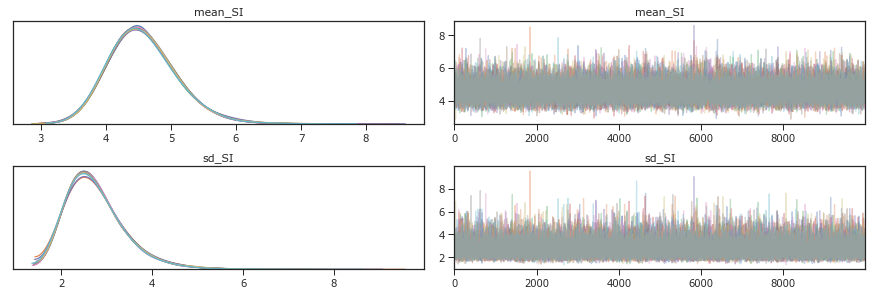

In [7]:
folder = "lognormal-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['s_raw','e_raw','logmean_SI','logsd_SI','s','e']))

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[ 1.         -0.16111064]
 [-0.16111064  1.        ]]
Covariance matrix
[[ 0.01166877 -0.00136984]
 [-0.00136984  0.00619532]]
Precision matrix
[[ 87.98257738  19.45366235]
 [ 19.45366235 165.7134015 ]]


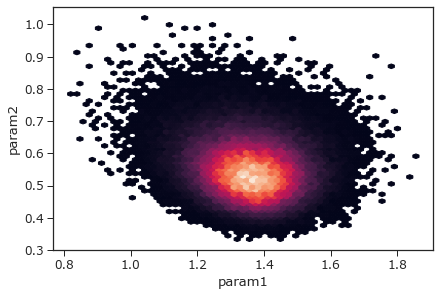

In [8]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

gamma-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.779,0.530,3.793,5.849,0.002,0.001,116518.0,109222.0,125366.0,74959.0,1.0
sd_SI,2.697,0.505,1.839,3.720,0.002,0.001,102271.0,90248.0,122909.0,71835.0,1.0
param1,3.331,0.918,1.667,5.146,0.003,0.002,125530.0,124151.0,120142.0,82145.0,1.0
param2,0.706,0.209,0.334,1.130,0.001,0.000,127894.0,127894.0,119706.0,79039.0,1.0


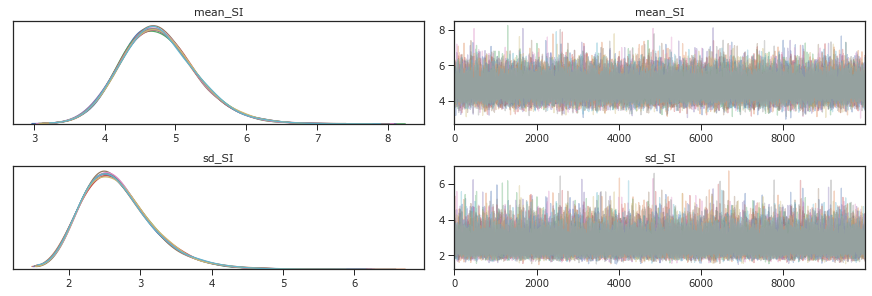

In [9]:
folder = "gamma-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))   

az.plot_trace(cmdstan_data, var_names = ['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data, credible_interval=0.95, var_names = ['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[1.         0.93445568]
 [0.93445568 1.        ]]
Covariance matrix
[[0.84216086 0.17922919]
 [0.17922919 0.04368225]]
Precision matrix
[[  9.36507132 -38.4250825 ]
 [-38.4250825  180.55150518]]


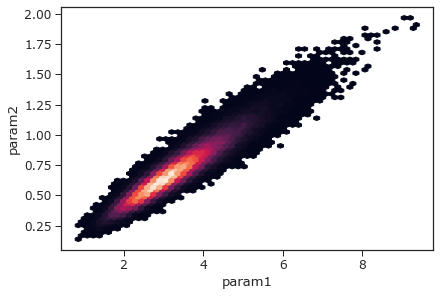

In [10]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

weibull-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.793,0.507,3.816,5.788,0.001,0.001,167974.0,156859.0,174491.0,75447.0,1.0
sd_SI,2.608,0.423,1.893,3.436,0.001,0.001,120711.0,99574.0,175305.0,68029.0,1.0
param1,1.950,0.293,1.381,2.526,0.001,0.000,176803.0,174412.0,173410.0,77761.0,1.0
param2,5.386,0.575,4.275,6.518,0.001,0.001,172538.0,163558.0,176168.0,77146.0,1.0


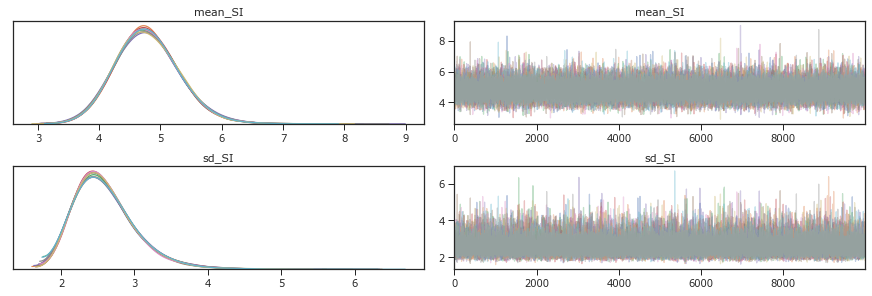

In [11]:
folder = "weibull-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data, credible_interval=0.95, var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[1.         0.26577747]
 [0.26577747 1.        ]]
Covariance matrix
[[0.08591116 0.04482661]
 [0.04482661 0.33112033]]
Precision matrix
[[12.52464317 -1.6955687 ]
 [-1.6955687   3.24959385]]


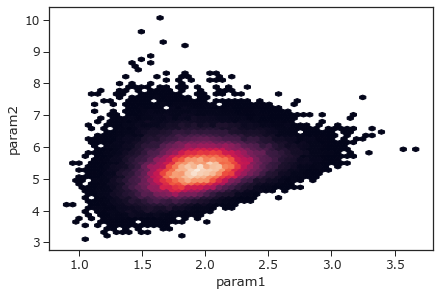

In [12]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

## Comparing different models

In [13]:
for truncation_type in ['no_truncation']:
    for idx, distrib in enumerate(distribs):
        folder = distrib+"-"+truncation_type
        print(colored(folder, 'red'))
        posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
        cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                                       log_likelihood="log_likelihood")
        param1 = cmdstan_data.posterior.param1.values.ravel()
        param2 = cmdstan_data.posterior.param2.values.ravel()
        df_params12 = pd.DataFrame({'param1': param1, 'param2': param2})
        df_params12.to_pickle(tracesdir+'/'+folder+'.pickle')
        df_params12.round(5).to_csv(tracesdir+'/'+folder+'.csv', index=False)
        cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s'])) 

        df_ = cmdstan_stats
        meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
        sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]

        if distrib=='gamma':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
            y = np.percentile(np.stack([ss.gamma(param1[idx],scale=1/param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='weibull':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html
            y = np.percentile(np.stack([ss.weibull_min(param1[idx],scale=param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='lognormal':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
            y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        output_ = [distrib,truncation_type,
              '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
              '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
              '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
              '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

        output = [output_] if idx==0 else np.r_[output, [output_]]
        print(output_)
        cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]


    output_df = pd.DataFrame(output,
                             columns=['Distribution', 'Truncation', 'mean', 
                                      'SD', 'q5', 'median', 'q95', 'q99'])

    models = dict([[distribs[idx], cmdstan_data_all[idx]] for idx in range(len(output))])
    stats_compare = az.compare(models, method='stacking', ic='waic', scale='deviance')

    df_stats_compare = stats_compare.reset_index().rename(columns={'index': 'Distribution'})
    df_stats_compare = df_stats_compare.loc[:,['Distribution','waic','d_waic','weight']]

    Df_ = df_stats_compare.merge(output_df)
    Df_['waic'] = [round(x,1) for x in Df_['waic']]
    Df_['d_waic'] = [round(x,2) for x in Df_['d_waic']]
    Df_['weight'] = [round(x,3) for x in Df_['weight']]
    display(Df_)

Df_.to_excel('../../results/Andrei/Stan-sims/summary-certain_and_probable-'+truncation_type+'.xlsx')

gamma-no_truncation
['gamma', 'no_truncation', '4.8 (3.9, 5.9)', '2.7 (1.9, 3.9)', '1.4 (0.7, 2.0)', '4.2 (3.4, 5.3)', '9.7 (7.7, 13.2)', '12.9 (9.9, 18.3)']
lognormal-no_truncation
['lognormal', 'no_truncation', '4.6 (3.7, 5.7)', '2.8 (1.8, 4.3)', '1.6 (1.0, 2.1)', '3.9 (3.1, 4.8)', '9.5 (7.4, 13.5)', '13.8 (10.1, 21.5)']
weibull-no_truncation
['weibull', 'no_truncation', '4.8 (3.9, 5.9)', '2.6 (2.0, 3.6)', '1.2 (0.6, 1.9)', '4.4 (3.5, 5.5)', '9.4 (7.8, 12.4)', '11.7 (9.4, 16.4)']


,Distribution,waic,d_waic,weight,Truncation,mean,SD,q5,median,q95,q99
0,lognormal,128.0,0.00,0.945,no_truncation,"4.6 (3.7, 5.7)","2.8 (1.8, 4.3)","1.6 (1.0, 2.1)","3.9 (3.1, 4.8)","9.5 (7.4, 13.5)","13.8 (10.1, 21.5)"
1,gamma,129.1,1.10,0.027,no_truncation,"4.8 (3.9, 5.9)","2.7 (1.9, 3.9)","1.4 (0.7, 2.0)","4.2 (3.4, 5.3)","9.7 (7.7, 13.2)","12.9 (9.9, 18.3)"
2,weibull,130.4,2.45,0.027,no_truncation,"4.8 (3.9, 5.9)","2.6 (2.0, 3.6)","1.2 (0.6, 1.9)","4.4 (3.5, 5.5)","9.4 (7.8, 12.4)","11.7 (9.4, 16.4)"


# With truncation

lognormal-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.699,0.587,3.624,5.856,0.002,0.001,92390.0,80980.0,114258.0,63415.0,1.0
sd_SI,2.936,0.802,1.717,4.500,0.003,0.002,73008.0,57288.0,107746.0,61234.0,1.0
param1,1.376,0.113,1.151,1.597,0.000,0.000,114212.0,113142.0,114819.0,83222.0,1.0
param2,0.567,0.086,0.409,0.735,0.000,0.000,88959.0,82065.0,99804.0,73233.0,1.0


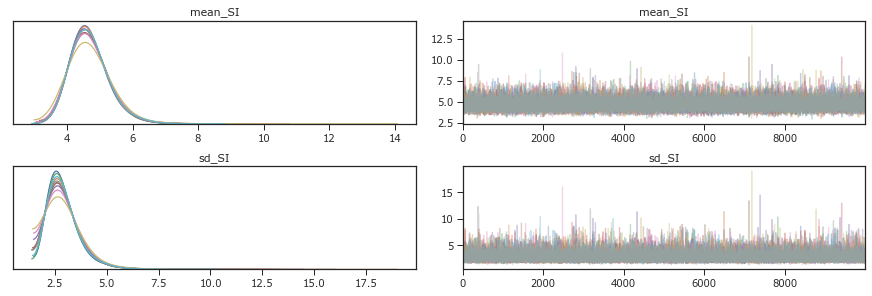

In [14]:
folder = "lognormal-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[ 1.        -0.0681637]
 [-0.0681637  1.       ]]
Covariance matrix
[[ 0.01273161 -0.00065979]
 [-0.00065979  0.00735901]]
Precision matrix
[[ 78.91128137   7.07496647]
 [  7.07496647 136.52222162]]


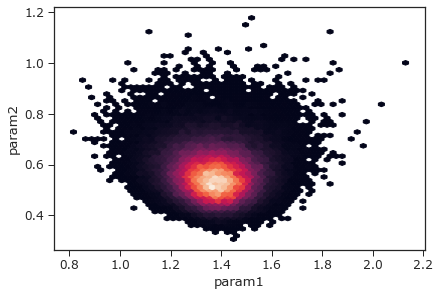

In [15]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

gamma-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.893,0.602,3.812,6.098,0.002,0.002,75266.0,62858.0,95863.0,58637.0,1.0
sd_SI,2.816,0.613,1.836,4.016,0.002,0.002,62871.0,43748.0,94386.0,56072.0,1.0
param1,3.234,0.925,1.564,5.093,0.003,0.002,111046.0,111046.0,103785.0,71342.0,1.0
param2,0.673,0.213,0.283,1.100,0.001,0.000,106138.0,106138.0,94882.0,62231.0,1.0


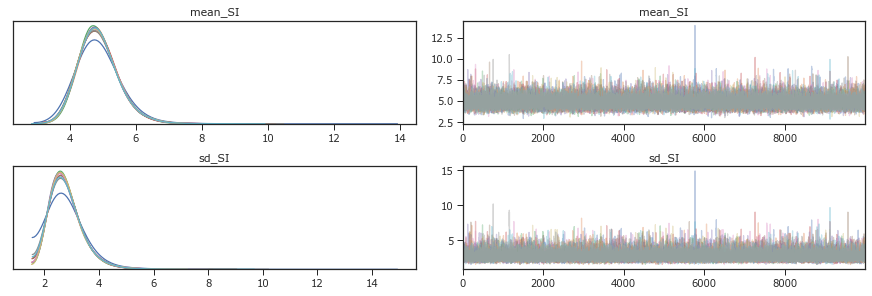

In [16]:
folder = "gamma-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[1.         0.93682621]
 [0.93682621 1.        ]]
Covariance matrix
[[0.85486961 0.18434438]
 [0.18434438 0.04529412]]
Precision matrix
[[  9.56032229 -38.90994089]
 [-38.90994089 180.43905497]]


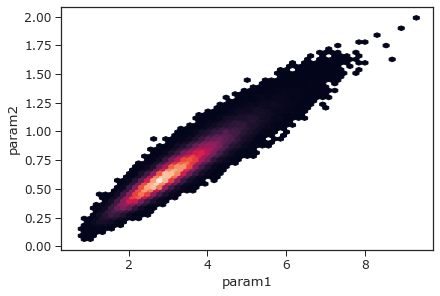

In [17]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

weibull-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.876,0.563,3.813,5.958,0.002,0.001,113249.0,93968.0,140871.0,63132.0,1.0
sd_SI,2.686,0.515,1.899,3.653,0.002,0.002,72640.0,53418.0,136611.0,58121.0,1.0
param1,1.931,0.299,1.357,2.527,0.001,0.001,142339.0,142339.0,138167.0,71978.0,1.0
param2,5.475,0.629,4.276,6.696,0.002,0.001,125164.0,107686.0,145017.0,65708.0,1.0


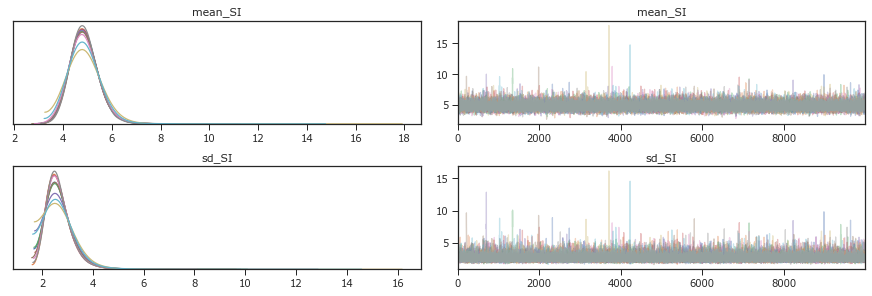

In [18]:
folder = "weibull-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[1.         0.15614211]
 [0.15614211 1.        ]]
Covariance matrix
[[0.08930707 0.02933986]
 [0.02933986 0.39535764]]
Precision matrix
[[11.47713857 -0.85172915]
 [-0.85172915  2.59256303]]


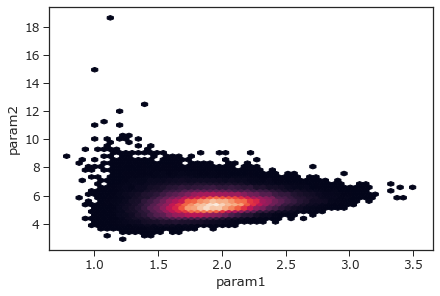

In [19]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

In [20]:
for truncation_type in ['truncated']:
    for idx, distrib in enumerate(distribs):
        folder = distrib+"-"+truncation_type
        
        print(colored(folder, 'red'))
        posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
        cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                                       log_likelihood="log_likelihood")
        param1 = cmdstan_data.posterior.param1.values.ravel()
        param2 = cmdstan_data.posterior.param2.values.ravel()
        df_params12 = pd.DataFrame({'param1': param1, 'param2': param2})
        df_params12.to_pickle(tracesdir+'/'+folder+'.pickle')
        df_params12.round(5).to_csv(tracesdir+'/'+folder+'.csv', index=False)
        cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

        df_ = cmdstan_stats
        meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
        sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]

        if distrib=='gamma':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
            y = np.percentile(np.stack([ss.gamma(param1[idx],scale=1/param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='weibull':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html
            y = np.percentile(np.stack([ss.weibull_min(param1[idx],scale=param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='lognormal':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
            y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        output_ = [distrib,truncation_type,
              '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
              '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
              '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
              '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

        output = [output_] if idx==0 else np.r_[output, [output_]]
        print(output_)
        cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]

    output_df = pd.DataFrame(output,
                             columns=['Distribution', 'Truncation', 'mean', 
                                      'SD', 'q5', 'median', 'q95', 'q99'])

    models = dict([[distribs[idx], cmdstan_data_all[idx]] for idx in range(len(output))])
    stats_compare = az.compare(models, method='stacking', ic='waic', scale='deviance')

    df_stats_compare = stats_compare.reset_index().rename(columns={'index': 'Distribution'})
    df_stats_compare = df_stats_compare.loc[:,['Distribution','waic','d_waic','weight']]

    Df_ = df_stats_compare.merge(output_df)
    Df_['waic'] = [round(x,1) for x in Df_['waic']]
    Df_['d_waic'] = [round(x,2) for x in Df_['d_waic']]
    Df_['weight'] = [round(x,3) for x in Df_['weight']]
    display(Df_)

Df_.to_excel('../../results/Andrei/Stan-sims/summary-certain_and_probable-'+truncation_type+'.xlsx')

gamma-truncated
['gamma', 'truncated', '4.9 (3.9, 6.3)', '2.8 (2.0, 4.3)', '1.4 (0.7, 2.1)', '4.3 (3.4, 5.5)', '10.0 (7.8, 14.7)', '13.2 (10.0, 20.7)']
lognormal-truncated
['lognormal', 'truncated', '4.7 (3.7, 6.0)', '2.9 (1.9, 4.9)', '1.6 (1.0, 2.1)', '4.0 (3.1, 4.9)', '9.8 (7.5, 14.8)', '14.4 (10.2, 24.4)']
weibull-truncated
['weibull', 'truncated', '4.9 (3.9, 6.1)', '2.7 (2.0, 3.9)', '1.2 (0.6, 1.9)', '4.5 (3.5, 5.6)', '9.6 (7.9, 13.3)', '12.0 (9.6, 17.9)']


,Distribution,waic,d_waic,weight,Truncation,mean,SD,q5,median,q95,q99
0,lognormal,224.0,0.00,1.0,truncated,"4.7 (3.7, 6.0)","2.9 (1.9, 4.9)","1.6 (1.0, 2.1)","4.0 (3.1, 4.9)","9.8 (7.5, 14.8)","14.4 (10.2, 24.4)"
1,gamma,225.4,1.39,0.0,truncated,"4.9 (3.9, 6.3)","2.8 (2.0, 4.3)","1.4 (0.7, 2.1)","4.3 (3.4, 5.5)","10.0 (7.8, 14.7)","13.2 (10.0, 20.7)"
2,weibull,226.8,2.77,0.0,truncated,"4.9 (3.9, 6.1)","2.7 (2.0, 3.9)","1.2 (0.6, 1.9)","4.5 (3.5, 5.6)","9.6 (7.9, 13.3)","12.0 (9.6, 17.9)"
